<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/hipoteza/hipoteza_model_z_data_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Classfier - Hypothesis Statement

Initializing the trainable parameters of a variational quantum circuit within a restricted range (e.g., $[-\frac{\pi}{4}, \frac{\pi}{4}]$) significantly improves the trainability of the model by ensuring non-vanishing initial gradients, thereby mitigating the Barren Plateau phenomenon compared to a standard uniform initialization in the range $[0, 2\pi]$.

Theoretical BackgroundIn Variational Quantum Algorithms (VQAs), such as the Quantum Neural Network (QNN) used in this project, we often encounter the Barren Plateau problem. This is a phenomenon where the gradient of the cost function becomes exponentially small as the number of qubits or the circuit depth increases.When weights are initialized randomly in a wide range (like $0$ to $2\pi$), the circuit effectively samples from a "unitary 2-design." This leads to a state that is highly entangled and "spread out" in the Hilbert space, where the variance of the gradient vanishes. By restricting the initialization range (Small Range Initialization), we keep the initial state closer to a known, non-random point (like the identity or the feature-mapped state), which preserves the gradient signal for the classical optimizer (Adam).

https://arxiv.org/abs/1803.11173
https://quantum-journal.org/papers/q-2019-12-09-214/

In [1]:
%pip install qiskit qiskit_machine_learning
%pip install ucimlrepo
%pip install torch
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.4 MB/s eta 0:00:00


In [2]:
%pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.8 MB/s eta 0:00:00


In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
from qiskit.primitives import StatevectorEstimator
#from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


In [4]:
import sys
import subprocess
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo
from qiskit import QuantumCircuit

def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

def prepare_data():
    """
    Fetches the banknote authentication dataset and returns scaled train/test splits.
    Features are scaled to [0, pi] specifically for Angle Encoding.
    """
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling to [0, pi] ensures data maps perfectly to Ry rotation angles
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def angle_encoding(data_point):
    """
    Creates a Feature Map circuit using Angle Encoding.
    Input: A 1D array of features (e.g., one row from X_train_scaled).
    Output: A Qiskit QuantumCircuit with Ry gates applied to each qubit.
    """
    num_qubits = len(data_point)
    qc = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        # Rotation by the exact value from normalization
        qc.ry(data_point[i], i)

    return qc

# Global availability of data
X_tr, X_te, y_tr, y_te = prepare_data()

Poniższy kod odpowiada za anstaz. Powstał on w oparciu o bibliteke Qiskit i korzysta z wbudowanych w nią funkcji, takich jak ParameterVektor służący do łatwego iterowania po parametrach bramek rotacyjnych. Sieć zakładay wykożystanie 4 qbitów oraz parzystej ilości warst. Każda warstwa składa się za podwarstwy niezależnych bramek oraz podwarstwy splątania.


Indeksy tych parametrów są numerowane od zera, a konstrukcja " j*n_qubits * 4 " upewnia się, że każda warstwa kożysta jedynie ze swoich parametrów.

In [5]:
def ansatz(n_qubits, depth):

    #Stworzenie parametrów bramek rotacyjnych
    theta = ParameterVector('θ', 8*depth)

    #Inicjalizacja układu
    qc = QuantumCircuit(n_qubits)

    #Pętla warst
    for j in range(depth//2):

        #Warstwa 1/3(0-7)(16-23)
        for i in range(n_qubits):
            qc.ry(theta[j*n_qubits*4+i], i)
        #Bariera upewnia się, że obliczeina zostaną wykonane liniowo, a nie skompresowane
        qc.barrier()

        qc.crx(theta[j*n_qubits*4+4], 3, 0)
        qc.crx(theta[j*n_qubits*4+5], 2, 3)
        qc.crx(theta[j*n_qubits*4+6], 1, 2)
        qc.crx(theta[j*n_qubits*4+7], 0, 1)
        qc.barrier()

        #Warstwa 2/4(8-15)(25-31)
        for i in range(n_qubits):
            qc.rx(theta[j*n_qubits*4+8 + i], i)
        qc.barrier()

        qc.cry(theta[j*n_qubits*4+12], 3, 2)
        qc.cry(theta[j*n_qubits*4+13], 0, 3)
        qc.cry(theta[j*n_qubits*4+14], 1, 0)
        qc.cry(theta[j*n_qubits*4+15], 2, 1)
        qc.barrier()

    return qc



In [6]:

class HybridModel:
    def __init__(self, ansatz_circuit, num_qubits):

        # we inicialize the variables
        self.num_qubits = num_qubits

        '''now we perform data encoding using ZZFetureMap, briefly it consist of three layers
        1. hadamard - puts all the qubits in superposition state |+>
        2. Z-Rotations - rotates each qubit individually based on input features Rz(x)
        3. ZZ-Rotations - it entangles qubits by rotating them based on the relationship between two features

        reps=1, we do the circuit of encoding only once. We can try and change that to 2 but it gets deeper
        '''
        #self.feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
        self.feature_map = self.create_angle_encoding(num_qubits)

        # Initalizing quantum circuit. Here we are connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map,qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)


        '''
        So that is a crucial step. Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.

        '''
        final_circuit_params = self.qc.parameters

        # creating dicts with names of the variables to then check them in our loop
        feature_map_names = {p.name for p in self.feature_map.parameters}
        ansatz_names = {p.name for p in ansatz_circuit.parameters}

        self.final_input_params = []
        self.final_weight_params = []

        for p in final_circuit_params:
            if p.name in feature_map_names:
                self.final_input_params.append(p)
            elif p.name in ansatz_names:
                self.final_weight_params.append(p)

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        '''Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.'''


        estimator = StatevectorEstimator()
        #estimator = Estimator()
        # creating a gradient for backward
        gradient = ParamShiftEstimatorGradient(estimator)
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=self.final_input_params,
            weight_params=self.final_weight_params,
            estimator=estimator,
            gradient = gradient
        )
    def create_angle_encoding(self, num_qubits):
        """
        Creates a Feature Map circuit using Angle Encoding with Parameters.
        Output: A Qiskit QuantumCircuit with Ry gates parametrized by x[0], x[1]...
        """
        qc = QuantumCircuit(num_qubits)
        # Tworzymy wektor parametrów 'x' o długości num_qubits
        input_params = ParameterVector('x', num_qubits)

        for i in range(num_qubits):
            # Rotacja Ry o kąt zdefiniowany przez parametr x[i]
            qc.ry(input_params[i], i)

        return qc

    # forward: gives the Estimator data and weights, sets the qubit angles, runs gates and measures the result
    def forward(self, x, weights):
        return self.qnn.forward(x, weights)

    # backward In Quantum ML it actually runs forward once again but with a little change
    # Firstly it shifts the angles by pi/2 and runs the circuit, then -pi/2 and runs the circuit
    # It calculates the difference and it's the gradient, we only return weight_grads because we dont need input_grads
    def backward(self, x, weights):
        _, weight_grads = self.qnn.backward(x, weights)
        if weight_grads is None:
            # If it fails, return zeros to prevent the loop from crashing
            print("Warning: Gradients were None. Returning Zeros.")
            return np.zeros((x.shape[0], len(weights)))
        return weight_grads


In [7]:
my_ansatz = ansatz(4, 4)
qnn = HybridModel(
    ansatz_circuit=my_ansatz,
    num_qubits=4,
)


# Initializing the weights
num_weights = qnn.qnn.num_weights
rng = np.random.default_rng(seed=42)

# HYPOTHESIS: Weight initialization in a narrow range to mitigate Barren Plateaus.
# Instead of a full [0, 2*pi] range, we use a smaller window around zero.
# This keeps the initial quantum state closer to the identity/feature-mapped state,
# ensuring stronger initial gradients for the Adam optimizer.
epsilon = np.pi / 4
weights = rng.uniform(-epsilon, epsilon, num_weights)

weights = weights.flatten()

# Output the initialization range to verify the experiment setup
print(f"Weights initialized in range: [{-epsilon:.4f}, {epsilon:.4f}]")
print(f"Total number of trainable parameters: {num_weights}")

Weights initialized in range: [-0.7854, 0.7854]
Total number of trainable parameters: 32


In [8]:
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.02

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

Loading data...
Data ready. Number of training samples: 1097


In [ ]:
# Preparing the adam optimizer, we create a PyTorch Tensor that will store weights and gradient history
weights_tensor = torch.tensor(weights, requires_grad=True, dtype=torch.float32)

optimizer = torch.optim.Adam([weights_tensor], lr=LEARNING_RATE)

print(f"Starting training... Model: HybridModel, Epochs: {EPOCHS}, LR: {LEARNING_RATE}")

# Training loop
for epoch in range(EPOCHS):
    # Shuffle data in each epoch
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=epoch)

    epoch_loss = 0.0
    batches_count = 0

    # Iterate through batches
    for i in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train_shuffled[i:i + BATCH_SIZE]
        y_batch = y_train_shuffled[i:i + BATCH_SIZE]

        # Convert weights to NumPy for Qiskit (as Qiskit does not accept PyTorch tensors)
        current_weights_numpy = weights_tensor.detach().numpy()

        # forward: model prediction (returns values from -1 to 1)
        pred = qnn.forward(X_batch, current_weights_numpy)

        # backward: calculation of weight gradients (returns numpy array)
        grads_numpy = qnn.backward(X_batch, current_weights_numpy)

        # Reshape only for y_batch, because pred coming out of QNN is already in (32,1) shape
        diff = pred - y_batch.reshape(-1, 1)
        loss = np.mean(diff ** 2)

        # Chain Rule: derivative of MSE
        grad_modifier = 2 * diff

        # CALCULATING THE GRADIENT
        # This gives us a simple matrix: row = sample, column = weight gradient
        grads_2d = grads_numpy.reshape(grads_numpy.shape[0], -1)

        # Weigh the gradients (Chain Rule)
        # Multiply each row of gradients by the error of that sample (grad_modifier)
        weighted_grads = grad_modifier * grads_2d

        # Calculate the average across the entire batch (axis=0 refers to rows)
        # This gives us a single gradient vector to update the weights
        batch_grads_numpy = np.mean(weighted_grads, axis=0)

        # WEIGHT UPDATE
        # Clear old gradients
        optimizer.zero_grad()

        # Pass our manually calculated gradient to the PyTorch tensor
        weights_tensor.grad = torch.from_numpy(batch_grads_numpy).float()

        optimizer.step()

        epoch_loss += loss
        batches_count += 1

    # Save trained weights back to the numpy variable
    weights = weights_tensor.detach().numpy()

    test_outputs = qnn.forward(X_test, weights)
    test_diff = test_outputs - y_test.reshape(-1, 1)
    test_loss = np.mean(test_diff ** 2)

    predicted = np.where(test_outputs > 0, 1, -1).flatten()

    test_accuracy = np.mean(predicted == y_test.flatten())

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")

Starting training... Model: HybridModel, Epochs: 20, LR: 0.02


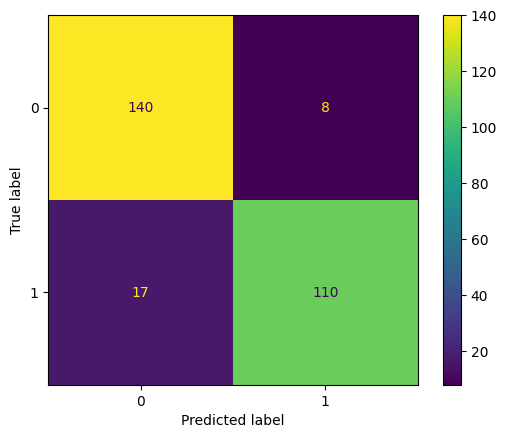

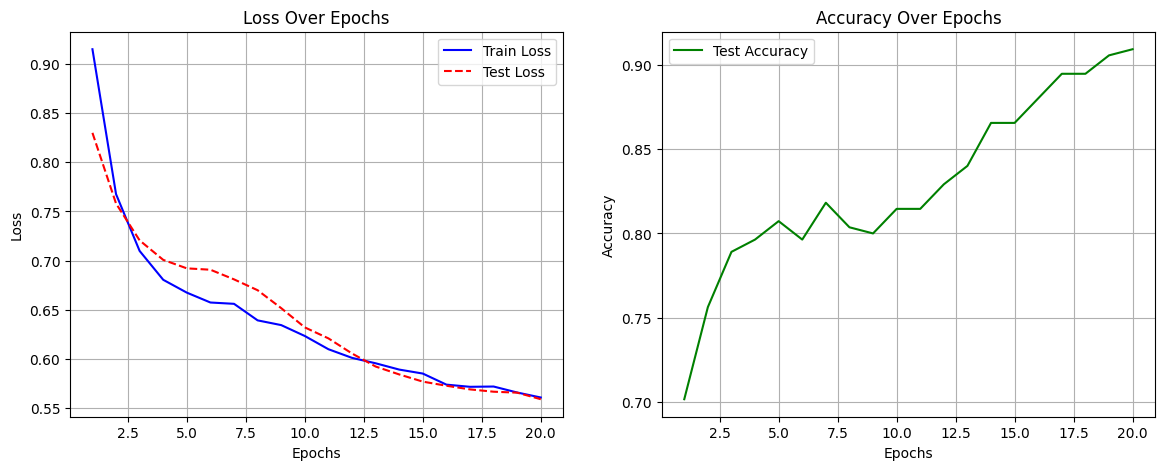

F1 SCORE:  0.8979591836734694  | ACCURACY SCORE:  0.9090909090909091


In [ ]:
test_outputs = qnn.forward(X_test, weights)
predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))